<a href="https://colab.research.google.com/github/Muntasir2179/bangla-accent-classification/blob/model-testing/Accent_Classification_optimization.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Importing libraries and dataset

In [1]:
!pip install resampy

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.1/3.1 MB 30.0 MB/s eta 0:00:00


In [2]:
# data visualization libraries
import resampy
import librosa
import pandas as pd
import os
import seaborn as sns
import numpy as np
from tqdm import tqdm
import matplotlib.pyplot as plt

# data preprocessing libraries
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder

# model building libraries
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Conv1D, MaxPooling1D, BatchNormalization, Dropout, Flatten, Conv2D, MaxPool2D

In [3]:
audio_dataset_path='/content/drive/MyDrive/Datasets/Bangla Accent Dataset/audio/'
metadata=pd.read_csv('/content/drive/MyDrive/Datasets/Bangla Accent Dataset/audio_trace_metadata.csv')

In [4]:
metadata = metadata.sample(frac=1, random_state=42)
metadata.head()

,file_name,folder_name,accent
482,madaripur_audio_42.wav,madaripur,madaripur
139,bogura_audio_25.wav,bogura,bogura
88,barishal_audio_74.wav,barishal,barishal
837,puran_dhaka_audio_102.wav,puran dhaka,puran dhaka
731,noakhali_audio_48.wav,noakhali,noakhali


In [5]:
len(metadata)

1093

In [6]:
metadata['accent'].value_counts()

noakhali       184
chottogram     147
barishal       114
puran dhaka    104
bogura         100
madaripur       90
kurigram        80
maymenshing     68
thakurgaon      66
rajshahi        43
pabna           42
shatkhira       33
sylhet          22
Name: accent, dtype: int64

# Extracting features

In [7]:
# defining a function that can extract features from audio files
import librosa

def features_extractor(file_name):
    audio, sample_rate = librosa.load(file_name, res_type='kaiser_fast')
    mfccs_features = librosa.feature.mfcc(y=audio, sr=sample_rate, n_mfcc=128)
    mfccs_scaled_features = np.mean(mfccs_features.T, axis=0)

    return mfccs_scaled_features

In [8]:
# collecting features for all the audio files

from tqdm import tqdm

extracted_features=[]

for index_num, row in tqdm(metadata.iterrows()):
  accent_label = row['accent']
  file_path = '/content/drive/MyDrive/Datasets/Bangla Accent Dataset/audio/' + str(row['folder_name']) + '/' + str(row['file_name'])
  data = features_extractor(file_path)
  extracted_features.append([data, accent_label])

1093it [08:19,  2.19it/s]


In [9]:
# converting extracted_features to Pandas dataframe
extracted_features_df=pd.DataFrame(extracted_features,columns=['feature','class'])
extracted_features_df.head()

,feature,class
0,"[-297.02393, 134.75122, 0.06768437, 23.073757,...",madaripur
1,"[-373.19098, 131.94902, -27.952295, 7.6782985,...",bogura
2,"[-314.02783, 114.90749, -42.842327, 27.550968,...",barishal
3,"[-317.07443, 90.44294, -5.8696094, 20.149368, ...",puran dhaka
4,"[-342.02744, 147.1966, -20.879251, 25.317888, ...",noakhali


In [10]:
# saving the extracted features dataframe into drive for later use
extracted_features_df.to_csv('/content/drive/MyDrive/Datasets/Bangla Accent Dataset/128_audio_features.csv')

In [11]:
# Split the dataset into independent and dependent dataset
X=np.array(extracted_features_df['feature'].tolist())
y=np.array(extracted_features_df['class'].tolist())

In [12]:
X.shape, y.shape

((1093, 128), (1093,))

# Applying onehot encoding on labels

In [13]:
encoder = OneHotEncoder()
y = encoder.fit_transform(y.reshape(-1, 1)).toarray()
y

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 1., 0., ..., 0., 0., 0.],
       [1., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 1., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 1.],
       [0., 0., 0., ..., 0., 0., 0.]])

In [14]:
y.shape

(1093, 13)

In [ ]:
import pickle
with open("/content/drive/MyDrive/Colab Notebooks/Accent Classification/Saved Models/onehot_encoder_accent_classification.pkl", "wb") as f:
    pickle.dump(encoder, f)

# Spliting dataset into train and test

In [15]:
# split the data to train and test set
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# print the details
print("Number of training samples = ", X_train.shape[0])
print("Number of testing samples = ", X_test.shape[0])

Number of training samples =  874
Number of testing samples =  219


# Helper functions for plotting and evaluation

In [16]:
# function for Ploting history (also known as a loss curve or a training curve)
def plot_history(history):
  plt.figure(figsize=(10, 5))
  plt.subplot(1, 2, 1)
  plt.plot(history.history['loss'], label='Training Loss')
  plt.plot(history.history['val_loss'], label='Validation Loss')
  plt.xlabel('Epochs')
  plt.ylabel('Loss')
  plt.legend()

  plt.subplot(1, 2, 2)
  plt.plot(history.history['accuracy'], label='Training Accuracy')
  plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
  plt.xlabel('Epochs')
  plt.ylabel('Accuracy')
  plt.legend()

  plt.tight_layout()
  plt.show()

In [17]:
# function to predict and generate decoded value of labels
def model_prediction(x_test, y_true, model, number_of_labels, onehot_encoder):
  y_pred = model.predict(x_test, verbose=0)
  predictions = []
  for row in y_pred:
    label = np.zeros(number_of_labels)
    label[np.argmax(row)] = 1
    label.reshape(1, -1)
    predictions.append(label.tolist())
    label = None
  y_test_decoded = onehot_encoder.inverse_transform(y_true)
  y_pred_decoded = onehot_encoder.inverse_transform(predictions)
  return y_pred_decoded, y_test_decoded

In [18]:
from sklearn.metrics import accuracy_score, classification_report, precision_score, recall_score, f1_score
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

def show_evaluation_parameters(X_test, y_test, ANN_Model, number_of_labels, encoder):
  predictions, y_test_for_eval = model_prediction(X_test, y_test, ANN_Model, number_of_labels, encoder)
  print('Accuracy score : ', accuracy_score(y_test_for_eval, predictions))
  print('Precision score: ', precision_score(y_test_for_eval, predictions, average='weighted'))
  print('Recall score   : ', recall_score(y_test_for_eval, predictions, average='weighted'))
  print('F1 Score       : ', f1_score(y_test_for_eval, predictions, average='weighted'))
  print('\n--------------------------------------------\n')
  print(classification_report(y_test_for_eval, predictions))

In [19]:
def show_confusion_matrix(X_test, y_test, ANN_Model, number_of_labels, encoder):
  predictions, y_test_for_eval = model_prediction(X_test, y_test, ANN_Model, number_of_labels, encoder)
  cm = confusion_matrix(y_test_for_eval, predictions, labels=metadata['accent'].unique())
  disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=metadata['accent'].unique())
  fig, ax = plt.subplots(figsize=(20,13))
  disp.plot(ax=ax)
  plt.show()

# Building ANN model

In [65]:
# Construct model
num_labels = y.shape[1]
ANN_Model = Sequential()
ANN_Model.add(Dense(1000, activation="relu", input_shape=(128,)))
ANN_Model.add(Dropout(0.1))
ANN_Model.add(Dense(750, activation="relu"))
ANN_Model.add(Dropout(0.1))
ANN_Model.add(Dense(500, activation="relu"))
ANN_Model.add(Dropout(0.1))
ANN_Model.add(Dense(250, activation="relu"))
ANN_Model.add(Dropout(0.1))
ANN_Model.add(Dense(100, activation="relu"))
ANN_Model.add(Dropout(0.1))
ANN_Model.add(Dense(50, activation="relu"))
ANN_Model.add(Dense(num_labels, activation="softmax"))

In [66]:
ANN_Model.compile(optimizer=tf.optimizers.Adam(learning_rate=0.0009),
                  loss="categorical_crossentropy",
                  metrics=["accuracy"])

In [67]:
class MyCallback(tf.keras.callbacks.Callback):
  def on_epoch_end(self, epoch, logs={}):
    if logs.get('val_accuracy') > 0.91:
      self.model.stop_training = True

callback = MyCallback()

In [68]:
num_epochs = 100
num_batch_size = 5

ANN_Results = ANN_Model.fit(X_train,
                            y_train,
                            batch_size=num_batch_size,
                            epochs=num_epochs,
                            validation_data=(X_test, y_test),
                            # callbacks=[callback]
                            )

Epoch 1/100
175/175 [==============================] - 4s 10ms/step - loss: 3.1048 - accuracy: 0.1293 - val_loss: 2.5306 - val_accuracy: 0.1370
Epoch 2/100
175/175 [==============================] - 1s 7ms/step - loss: 2.4326 - accuracy: 0.1865 - val_loss: 2.3621 - val_accuracy: 0.1689
Epoch 3/100
175/175 [==============================] - 1s 6ms/step - loss: 2.2243 - accuracy: 0.2162 - val_loss: 2.0986 - val_accuracy: 0.2603
Epoch 4/100
175/175 [==============================] - 1s 6ms/step - loss: 1.9520 - accuracy: 0.3330 - val_loss: 1.8351 - val_accuracy: 0.3927
Epoch 5/100
175/175 [==============================] - 1s 6ms/step - loss: 1.7844 - accuracy: 0.3959 - val_loss: 1.6174 - val_accuracy: 0.4703
Epoch 6/100
175/175 [==============================] - 1s 5ms/step - loss: 1.4321 - accuracy: 0.5149 - val_loss: 1.5330 - val_accuracy: 0.5160
Epoch 7/100
175/175 [==============================] - 1s 5ms/step - loss: 1.2682 - accuracy: 0.5904 - val_loss: 1.2212 - val_accuracy: 0.566

In [69]:
test_accuracy=ANN_Model.evaluate(X_test, y_test, verbose=0)
print(test_accuracy[1])

0.8767123222351074


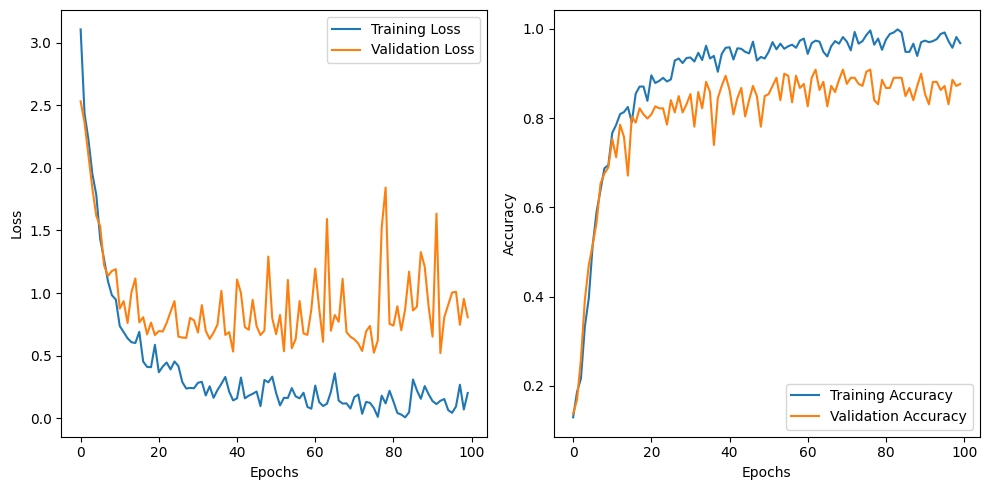

In [70]:
plot_history(ANN_Results)

In [71]:
show_evaluation_parameters(X_test, y_test, ANN_Model, num_labels, encoder)

Accuracy score :  0.8767123287671232
Precision score:  0.8736448140900195
Recall score   :  0.8767123287671232
F1 Score       :  0.8729519369911962

--------------------------------------------

              precision    recall  f1-score   support

    barishal       0.94      0.94      0.94        32
      bogura       0.91      0.91      0.91        22
  chottogram       0.93      0.84      0.88        31
    kurigram       1.00      1.00      1.00        13
   madaripur       1.00      1.00      1.00        14
 maymenshing       0.81      1.00      0.90        13
    noakhali       0.83      0.83      0.83        30
       pabna       1.00      0.88      0.93         8
 puran dhaka       0.76      0.83      0.79        23
    rajshahi       0.25      0.14      0.18         7
   shatkhira       1.00      0.89      0.94         9
      sylhet       0.50      0.67      0.57         3
  thakurgaon       0.88      1.00      0.93        14

    accuracy                           0.88    

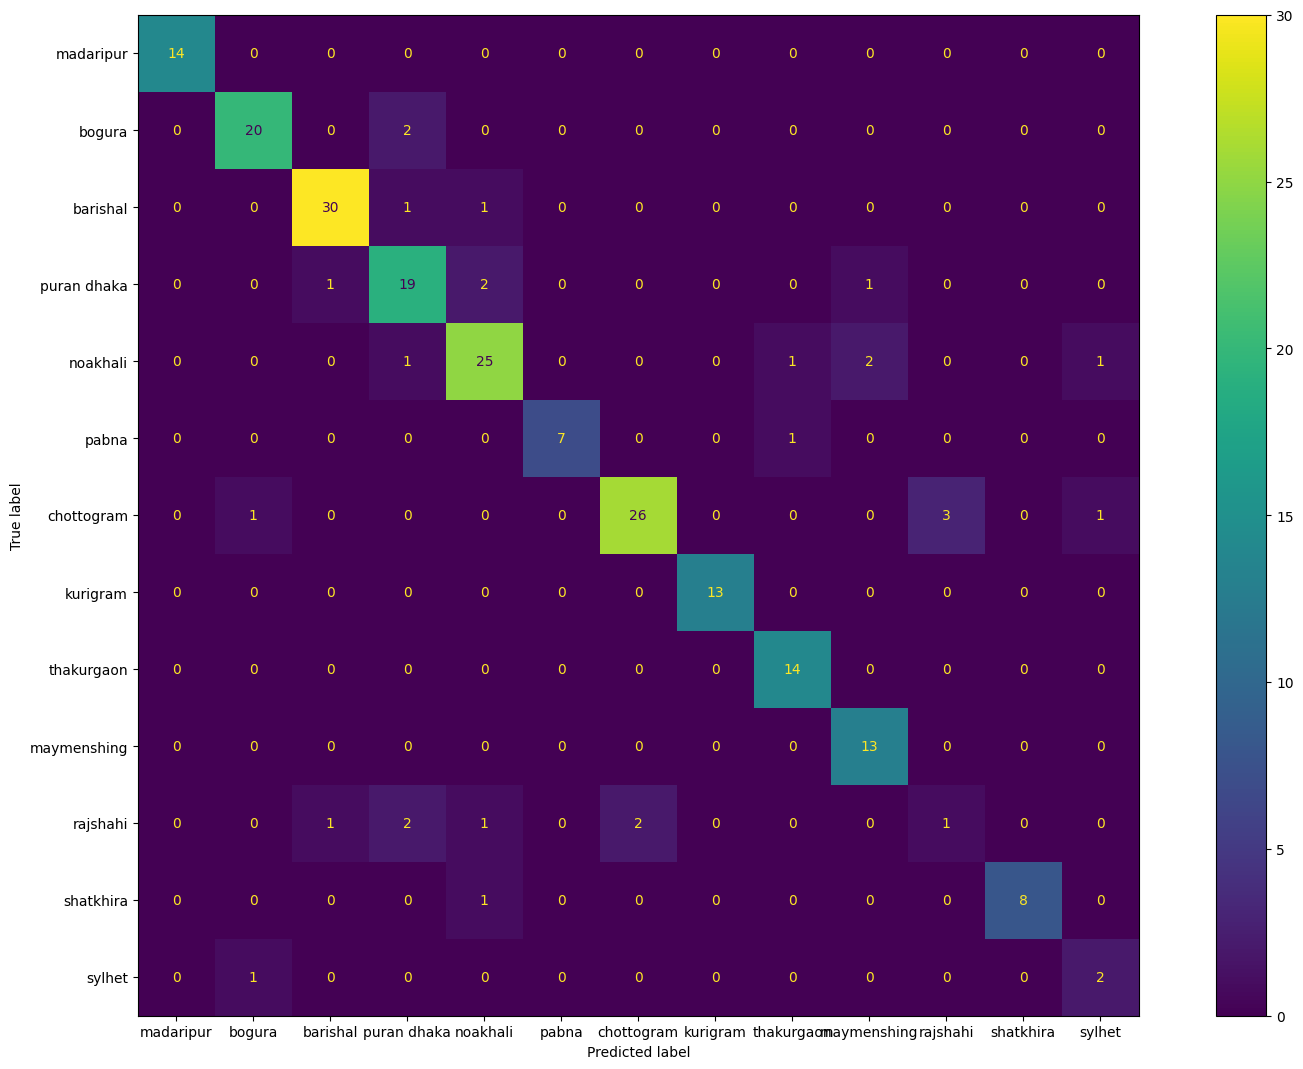

In [72]:
show_confusion_matrix(X_test, y_test, ANN_Model, num_labels, encoder)

In [ ]:
# saving the model
ANN_Model.save('/content/drive/MyDrive/Colab Notebooks/Accent Classification/Saved Models/ANN_Model_val_acc_93%.h5')

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [ ]:
# loading the model
loaded_ann_model = tf.keras.models.load_model('/content/drive/MyDrive/Colab Notebooks/Accent Classification/Saved Models/ANN_Model_val_acc_93%.h5')

In [ ]:
result = loaded_ann_model.evaluate(X_test, y_test, verbose=0)
print(result[1])

0.9281768202781677


# Building CNN1D model

In [73]:
CNN1D_Model = Sequential()
CNN1D_Model.add(Conv1D(256, 5, strides=1, padding="same", activation="relu", input_shape=(X_train.shape[1], 1),))
CNN1D_Model.add(BatchNormalization())
CNN1D_Model.add(MaxPooling1D(3, strides=2, padding="same"))
CNN1D_Model.add(Conv1D(256, 5, strides=1, padding="same", activation="relu"))
CNN1D_Model.add(Dropout(0.3))
CNN1D_Model.add(MaxPooling1D(3, strides=2, padding="same"))
CNN1D_Model.add(Conv1D(128, 5, strides=1, padding="same", activation="relu"))
CNN1D_Model.add(Dropout(0.3))
CNN1D_Model.add(MaxPooling1D(3, strides=2, padding="same"))
CNN1D_Model.add(Conv1D(64, 5, strides=1, padding="same", activation="relu"))
CNN1D_Model.add(Dropout(0.3))
CNN1D_Model.add(MaxPooling1D(3, strides=2, padding="same"))
CNN1D_Model.add(Flatten())
CNN1D_Model.add(Dense(units=1024, activation="relu"))
CNN1D_Model.add(Dropout(0.3))
CNN1D_Model.add(Dense(units=num_labels, activation="softmax"))

In [74]:
CNN1D_Model.compile(optimizer="adam",
                    loss="categorical_crossentropy",
                    metrics=["accuracy"])

In [75]:
CNN1D_Results = CNN1D_Model.fit(X_train,
                                y_train,
                                batch_size=5,
                                epochs=250,
                                validation_data=(X_test, y_test))

Epoch 1/250
175/175 [==============================] - 11s 13ms/step - loss: 2.6647 - accuracy: 0.1659 - val_loss: 2.2824 - val_accuracy: 0.2055
Epoch 2/250
175/175 [==============================] - 1s 8ms/step - loss: 2.3653 - accuracy: 0.2014 - val_loss: 2.2551 - val_accuracy: 0.2283
Epoch 3/250
175/175 [==============================] - 1s 7ms/step - loss: 2.2418 - accuracy: 0.2551 - val_loss: 2.0916 - val_accuracy: 0.2192
Epoch 4/250
175/175 [==============================] - 1s 7ms/step - loss: 1.9487 - accuracy: 0.3238 - val_loss: 1.9295 - val_accuracy: 0.4018
Epoch 5/250
175/175 [==============================] - 1s 7ms/step - loss: 1.8658 - accuracy: 0.3650 - val_loss: 1.7366 - val_accuracy: 0.4155
Epoch 6/250
175/175 [==============================] - 1s 8ms/step - loss: 1.7390 - accuracy: 0.4211 - val_loss: 1.6494 - val_accuracy: 0.5023
Epoch 7/250
175/175 [==============================] - 1s 7ms/step - loss: 1.5471 - accuracy: 0.4943 - val_loss: 1.5061 - val_accuracy: 0.54

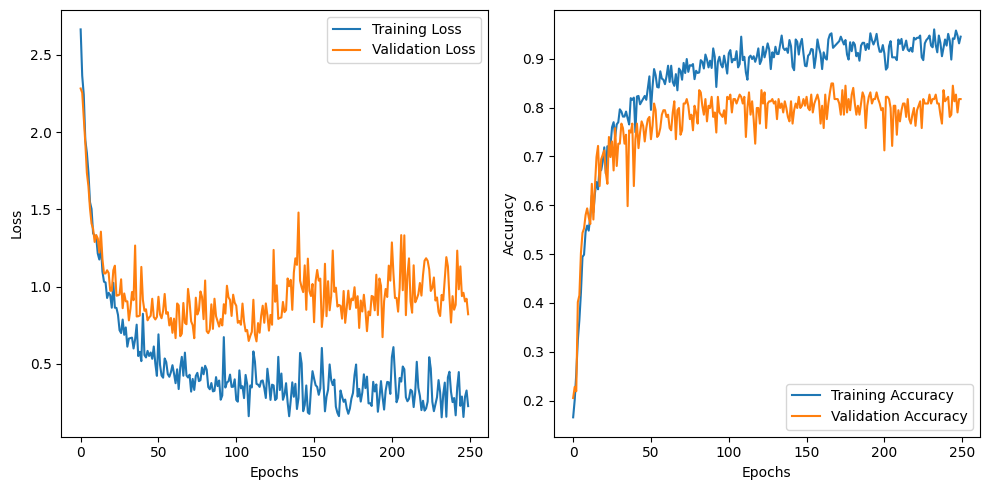

In [76]:
plot_history(CNN1D_Results)

In [77]:
show_evaluation_parameters(X_test, y_test, CNN1D_Model, num_labels, encoder)

Accuracy score :  0.817351598173516
Precision score:  0.8255601375520328
Recall score   :  0.817351598173516
F1 Score       :  0.8113324733922601

--------------------------------------------

              precision    recall  f1-score   support

    barishal       0.93      0.84      0.89        32
      bogura       0.95      0.82      0.88        22
  chottogram       0.74      0.94      0.83        31
    kurigram       0.82      0.69      0.75        13
   madaripur       1.00      1.00      1.00        14
 maymenshing       1.00      0.69      0.82        13
    noakhali       0.68      0.83      0.75        30
       pabna       0.88      0.88      0.88         8
 puran dhaka       0.75      0.91      0.82        23
    rajshahi       0.50      0.14      0.22         7
   shatkhira       1.00      1.00      1.00         9
      sylhet       0.33      0.33      0.33         3
  thakurgaon       0.82      0.64      0.72        14

    accuracy                           0.82      

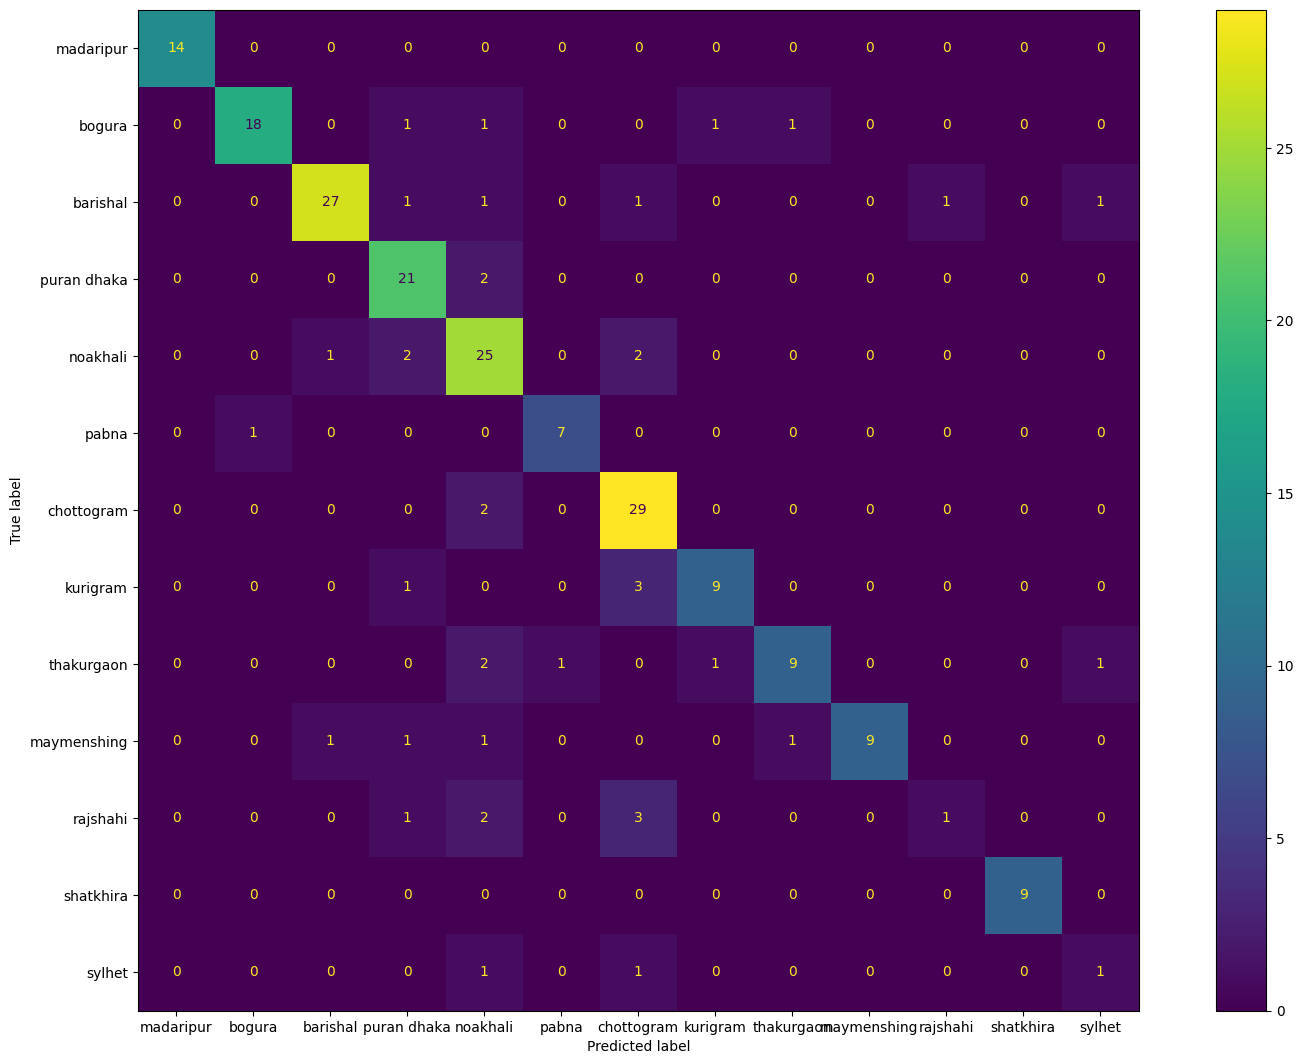

In [78]:
show_confusion_matrix(X_test, y_test, CNN1D_Model, num_labels, encoder)

# Building CNN2D model

In [79]:
# reshaping features to pass into the model
X_train_reshaped = X_train.reshape(X_train.shape[0], 16, 8, 1)
X_test_reshaped = X_test.reshape(X_test.shape[0], 16, 8, 1)

In [107]:
CNN2D_Model = Sequential()
CNN2D_Model.add(Conv2D(64, (3, 3), padding="same", activation="tanh", input_shape=(16, 8, 1)))
CNN2D_Model.add(MaxPool2D(pool_size=(2, 2)))
CNN2D_Model.add(Conv2D(128, (3, 3), padding="same", activation="tanh"))
CNN2D_Model.add(MaxPool2D(pool_size=(2, 2)))
CNN2D_Model.add(Dropout(0.1))
CNN2D_Model.add(Flatten())
CNN2D_Model.add(Dense(256, activation="tanh"))
CNN2D_Model.add(Dense(num_labels, activation="softmax"))

In [108]:
CNN2D_Model.compile(optimizer=tf.optimizers.Adam(learning_rate=0.001),
                    loss="categorical_crossentropy",
                    metrics=["accuracy"])

In [109]:
CNN2D_Results = CNN2D_Model.fit(X_train_reshaped,
                                y_train,
                                batch_size=5,
                                epochs=13,
                                validation_data=(X_test_reshaped, y_test))

Epoch 1/13
175/175 [==============================] - 2s 6ms/step - loss: 1.7713 - accuracy: 0.4428 - val_loss: 1.3838 - val_accuracy: 0.5662
Epoch 2/13
175/175 [==============================] - 1s 7ms/step - loss: 0.9914 - accuracy: 0.6934 - val_loss: 1.6460 - val_accuracy: 0.5571
Epoch 3/13
175/175 [==============================] - 1s 7ms/step - loss: 0.6248 - accuracy: 0.8124 - val_loss: 0.8888 - val_accuracy: 0.7534
Epoch 4/13
175/175 [==============================] - 1s 7ms/step - loss: 0.4309 - accuracy: 0.8810 - val_loss: 0.8947 - val_accuracy: 0.7580
Epoch 5/13
175/175 [==============================] - 1s 5ms/step - loss: 0.2517 - accuracy: 0.9256 - val_loss: 0.7794 - val_accuracy: 0.7763
Epoch 6/13
175/175 [==============================] - 1s 5ms/step - loss: 0.1675 - accuracy: 0.9428 - val_loss: 1.0401 - val_accuracy: 0.7352
Epoch 7/13
175/175 [==============================] - 1s 5ms/step - loss: 0.0891 - accuracy: 0.9725 - val_loss: 0.6090 - val_accuracy: 0.8128
Epoch 

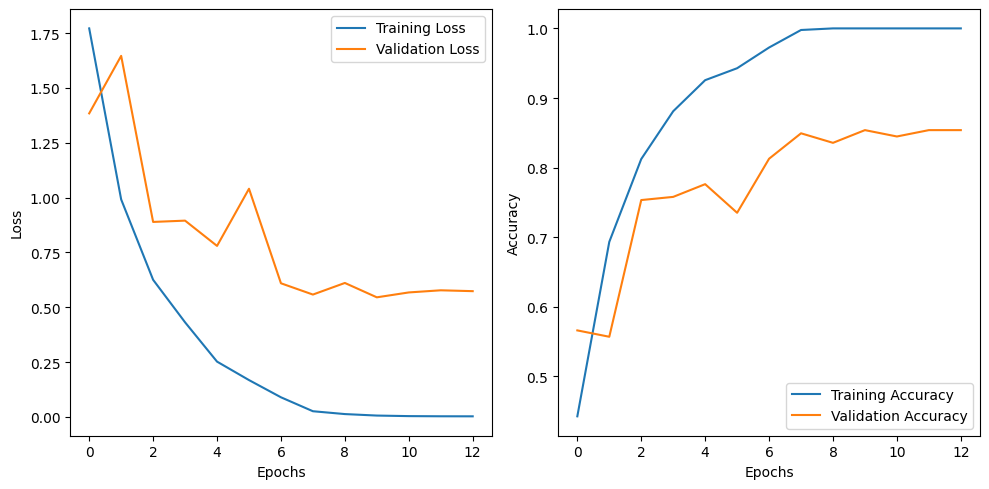

In [110]:
plot_history(CNN2D_Results)

In [111]:
show_evaluation_parameters(X_test_reshaped, y_test, CNN2D_Model, num_labels, encoder)

Accuracy score :  0.8538812785388128
Precision score:  0.8589541406976943
Recall score   :  0.8538812785388128
F1 Score       :  0.8530964003012761

--------------------------------------------

              precision    recall  f1-score   support

    barishal       0.93      0.88      0.90        32
      bogura       0.95      0.91      0.93        22
  chottogram       0.78      0.81      0.79        31
    kurigram       1.00      1.00      1.00        13
   madaripur       0.88      1.00      0.93        14
 maymenshing       1.00      0.92      0.96        13
    noakhali       0.74      0.83      0.78        30
       pabna       0.73      1.00      0.84         8
 puran dhaka       0.95      0.83      0.88        23
    rajshahi       0.50      0.29      0.36         7
   shatkhira       1.00      1.00      1.00         9
      sylhet       0.25      0.33      0.29         3
  thakurgaon       0.85      0.79      0.81        14

    accuracy                           0.85    

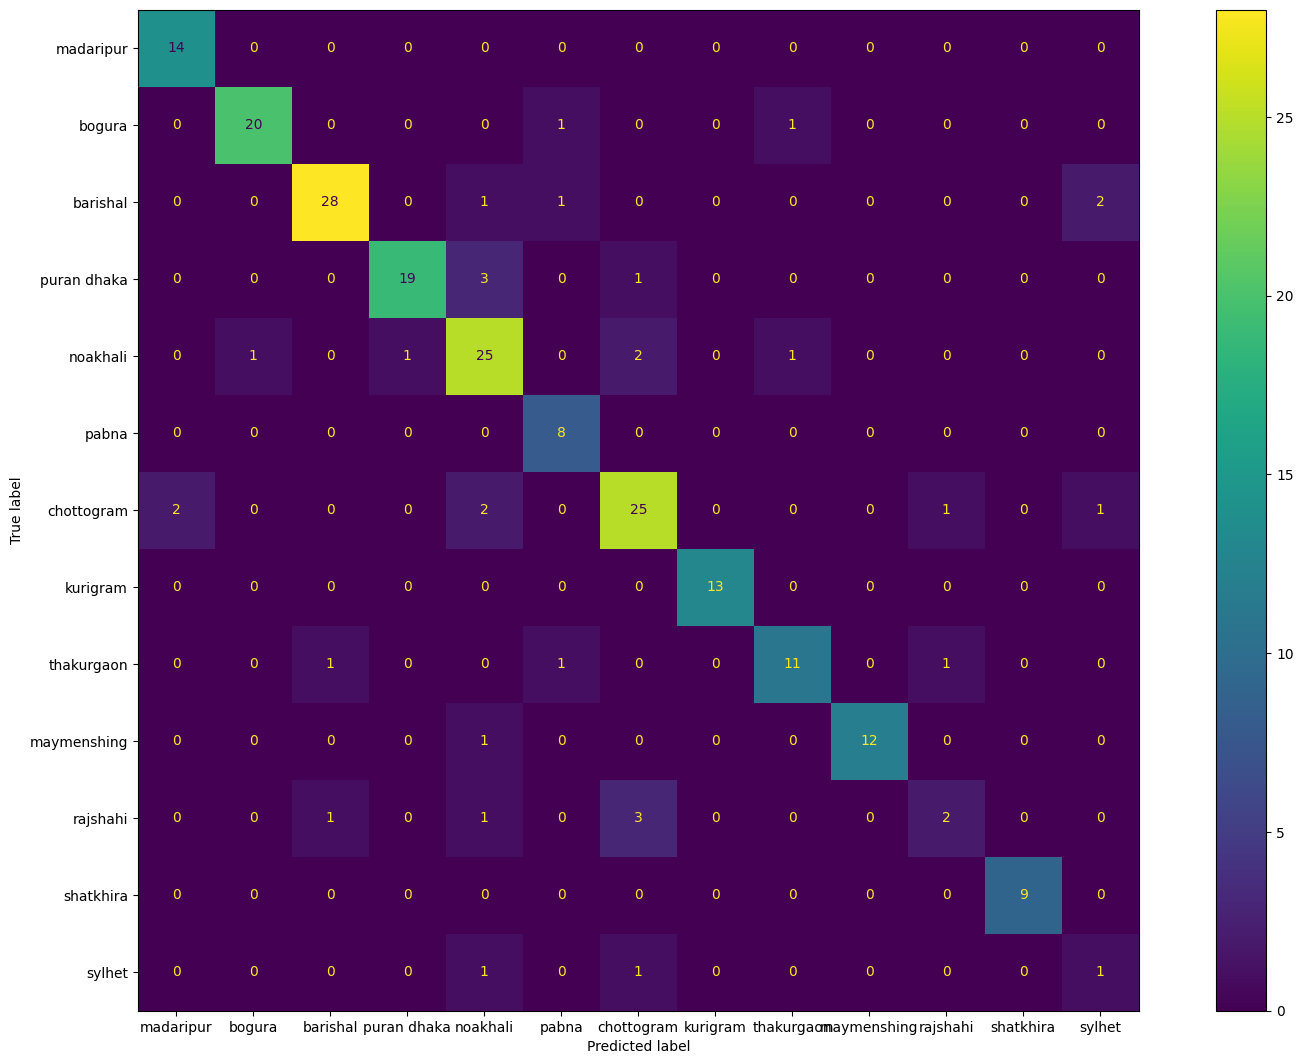

In [112]:
show_confusion_matrix(X_test_reshaped, y_test, CNN2D_Model, num_labels, encoder)